In [2]:
%matplotlib inline
import tensorflow as tf
global tf
from IPython.display import display, HTML
import python_utils as utils
from natsort import natsorted
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import itertools
from itertools import cycle
from collections import defaultdict
from scipy import interp

import sklearn
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.utils import shuffle
from sklearn.multiclass import OneVsRestClassifier

import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras import optimizers, regularizers
from keras.optimizers import Adam
from keras.backend.tensorflow_backend import set_session
from tensorboard.plugins.pr_curve import summary as pr_summary

Using TensorFlow backend.


In [58]:
name = 't-SNE_test'
path_to_TB = os.getcwd()+'/AUC_ROC/TB_data'
call_tensorboard = keras.callbacks.TensorBoard(log_dir=path_to_TB+'logs/{}'.format(name))
filepath = path_to_TB + "/checkpoint/" + name + "-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
call_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [call_tensorboard, call_checkpoint]

In [4]:
def report2dict(cr):
    # Parse rows
    tmp = list()
    for row in cr.split("\n"):
        parsed_row = [x for x in row.split("  ") if len(x) > 0]
        if len(parsed_row) > 0:
            tmp.append(parsed_row)
    
    # Store in dictionary
    measures = tmp[0]

    D_class_data = defaultdict(dict)
    for row in tmp[1:]:
        class_label = row[0]
        for j, m in enumerate(measures):
            D_class_data[class_label][m.strip()] = float(row[j + 1].strip())
    return D_class_data


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('Confusion_matrix.png', dpi=200, format='png', bbox_inches='tight')
    plt.show()
    
plt.show()
def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))

def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 2)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)


def draw_heat_map(report):
    plot_classification_report(report)
    plt.savefig('test_plot_classif_report.png', dpi=200, format='png', bbox_inches='tight')
    plt.show()
    plt.close()
       
def predictions_to_label_array(predictions_array):
    predictions_one_hot_encode = []
    for array in predictions_array:
        result_per__iteration = []
        for value in array:
            if value < max(array):
                result_per__iteration.append(0)
            elif value == max(array):
                result_per__iteration.append(1)
            else:
                result_per__iteration.append(0)
        predictions_one_hot_encode.append(result_per__iteration)
    return([np.where(r==1)[0][0] for r in np.array(predictions_one_hot_encode)])

In [5]:
sns.set()

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#x_train = x_train.reshape(60000, 784) / 255
#x_test = x_test.reshape(10000, 784) / 255

In [7]:
#X = x_train[:30000]
#Y = y_train[:30000]

In [8]:
time_start = time.time()

tsne = TSNE(n_components=2, verbose=1)
tsne_results = tsne.fit_transform(x_train)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 60000 samples in 13.600s...
[t-SNE] Computed neighbors for 60000 samples in 3690.520s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for

In [13]:
np.save('tsne_results.npy', tsne_results)

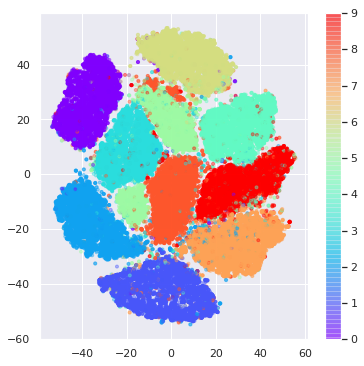

In [11]:
plt.figure(figsize=(6, 6))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=y_train,
            alpha=.4, s=3**2, cmap='rainbow')
plt.colorbar()
plt.show()

In [3]:
tsne_results = np.load('tsne_results.npy')

In [4]:
tsne_results.shape

(60000, 2)

In [9]:
train, validate, test = np.split(tsne_results, [int(.9*len(tsne_results)), int(.95*len(tsne_results))])

In [10]:
print('{}{}{}'.format(train.shape, validate.shape, test.shape))

(54000, 2)(3000, 2)(3000, 2)


In [11]:
train

array([[  0.2115259 ,  16.278511  ],
       [-40.405952  ,  22.416164  ],
       [ 34.405113  ,  25.373882  ],
       ...,
       [-29.278818  ,  -0.62114674],
       [ 32.69169   ,  -1.7424189 ],
       [-42.214333  ,  15.515296  ]], dtype=float32)

In [12]:
train, validate, test = train.reshape(54000, 2) / 255 , validate.reshape(3000, 2) / 255, test.reshape(3000,2) / 255

In [13]:
train_y, validate_y, test_y = np.split(y_train, [int(.9*len(y_train)), int(.95*len(y_train))])

(3000,)

In [12]:
num_classes=10

In [13]:
train_y =  keras.utils.to_categorical(train_y, num_classes)
validate_y = keras.utils.to_categorical(validate_y, num_classes)
test_y = keras.utils.to_categorical(test_y, num_classes)

In [24]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=2))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 128)               384       
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               66048     
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               65664     
__________

In [25]:
def optimize_and_fit(model, lr, epochs):
        Adam = optimizers.Adam(lr=lr)
        model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit(x=train, y=train_y, batch_size =64, 
                    validation_data = (validate, validate_y),
                    callbacks = callbacks_list,
                    epochs = epochs,
                    shuffle = True,
                    verbose = 1
                    )

In [56]:
optimize_and_fit(model, 1e-4, 1000)

Train on 54000 samples, validate on 3000 samples


AttributeError: 'Sequential' object has no attribute '_feed_outputs'

In [27]:
predictions = model.predict(test, batch_size=128, verbose=1)

3000/3000 [==============================] - 0s 28us/step


In [82]:
type(predictions)

numpy.ndarray

Confusion matrix, without normalization
[[291   0   1   1   0   0   2   2   0   0]
 [  0 325   0   0   0   0   0   0   0   0]
 [  1   0 301   1   0   0   0   5   1   0]
 [  0   0   0 307   0   2   0   0   5   0]
 [  0   4   0   0 280   0   0   1   0   5]
 [  0   0   0   5   0 251   4   0   1   1]
 [  0   0   0   0   0   1 287   0   0   0]
 [  0   2   0   0   0   0   0 329   0   1]
 [  0   1   0   0   0   6   0   0 289   1]
 [  0   0   0   2   1   3   0   2   0 278]]


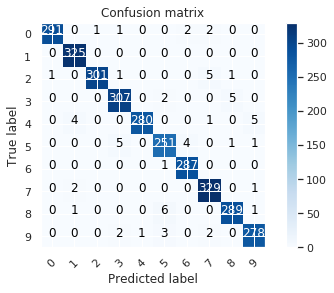

In [28]:
prediction_label, true_label = predictions_to_label_array(predictions), predictions_to_label_array(test_y)
cm = confusion_matrix(true_label, prediction_label)
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm, cm_plot_labels,
                          title='Confusion matrix')

In [29]:
report = classification_report(true_label, prediction_label, target_names=cm_plot_labels)

In [30]:
report_df = pd.DataFrame(report2dict(report)).T
report_df

,f1-score,precision,recall,support
0,0.99,1.00,0.98,297.0
1,0.99,0.98,1.00,325.0
2,0.99,1.00,0.97,309.0
3,0.97,0.97,0.98,314.0
4,0.98,1.00,0.97,290.0
5,0.96,0.95,0.96,262.0
6,0.99,0.98,1.00,288.0
7,0.98,0.97,0.99,332.0
8,0.97,0.98,0.97,297.0
9,0.97,0.97,0.97,286.0


[1.0, 0.98, 0.99]
[0.98, 1.0, 0.99]
[1.0, 0.97, 0.99]
[0.97, 0.98, 0.97]
[1.0, 0.97, 0.98]
[0.95, 0.96, 0.96]
[0.98, 1.0, 0.99]
[0.97, 0.99, 0.98]
[0.98, 0.97, 0.97]
[0.97, 0.97, 0.97]
plotMat: [[1.0, 0.98, 0.99], [0.98, 1.0, 0.99], [1.0, 0.97, 0.99], [0.97, 0.98, 0.97], [1.0, 0.97, 0.98], [0.95, 0.96, 0.96], [0.98, 1.0, 0.99], [0.97, 0.99, 0.98], [0.98, 0.97, 0.97], [0.97, 0.97, 0.97]]
support: [297, 325, 309, 314, 290, 262, 288, 332, 297, 286]


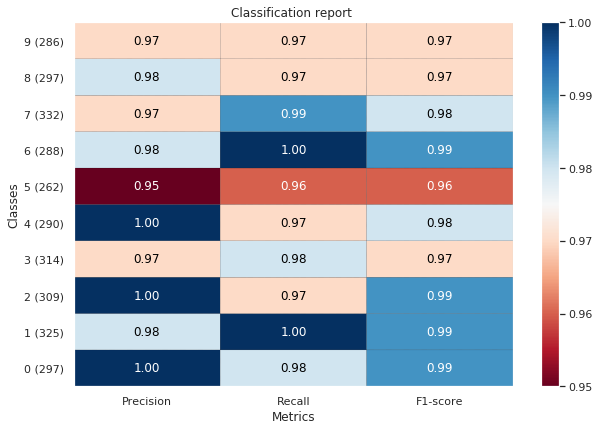

In [31]:
draw_heat_map(report)

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

In [109]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_y.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

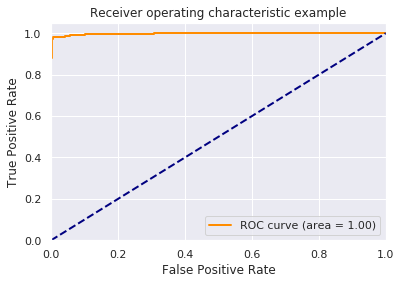

In [110]:
plt.figure()
lw = 2
plt.plot(fpr[8], tpr[8], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

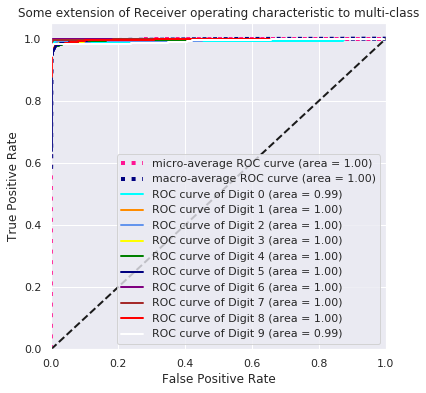

In [112]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(6, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'yellow', 'green', 'navy', 'purple', 'brown', 'red', 'white'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of Digit {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

#plt.scatter(tsne_results[:,0], tsne_results[:,1], c=y_train,
#            alpha=.4, s=3**2, cmap='rainbow')
#plt.colorbar()
#plt.show()    
    

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()